### Dataset
The Apple stock price comes from the Yahoo Finance library in python. 

In [2]:
# Importing all necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Download historical stock price data
stock_data = yf.download("AAPL", start="2024-01-01", end="2024-12-31", progress=False)

# Show the first few rows of the data
stock_data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2024-01-02,184.081512,186.858009,182.346204,185.578830,82488700
2024-01-03,182.703156,184.319476,181.890032,182.673409,58414500
2024-01-04,180.382843,181.552929,179.361491,180.620818,71983600
2024-01-05,179.658936,181.225673,178.657420,180.462148,62379700
2024-01-08,184.002182,184.041855,179.976269,180.561312,59144500


In [4]:
# Isolating the relevant data - stock price at close
stock_data['Close'].describe()

Ticker,AAPL
count,251.000000
mean,205.865365
std,25.527263
min,163.823563
25%,182.770088
50%,213.001007
75%,226.285316
max,258.103729


### Box-Jenkins Test
For ARIMA, we’ll focus on the Close price. We’ll also check if the data is stationary and make it stationary if needed.

<Figure size 1080x1080 with 0 Axes>

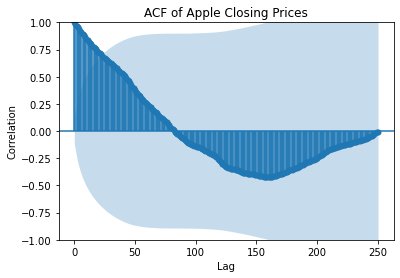

In [6]:
appl = stock_data['Close']

# Plot ACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(15,15))
plot_acf(appl, lags=250)  # show up to 40 lags
plt.title("ACF of Apple Closing Prices")
plt.xlabel('Lag') 
plt.ylabel('Correlation')
plt.show()

<Figure size 1080x1080 with 0 Axes>

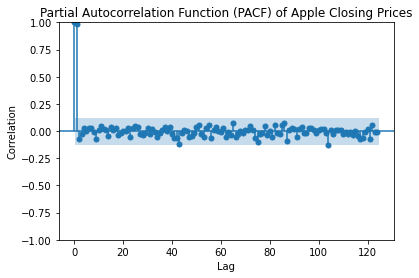

In [7]:
# Plot PACF
plt.figure(figsize=(15,15))
plot_pacf(appl, lags=124, method="ywm")  # 'ywm' = Yule-Walker method (common choice)
plt.title("Partial Autocorrelation Function (PACF) of Apple Closing Prices")
plt.xlabel('Lag') 
plt.ylabel('Correlation')
plt.show()

In [8]:
# Perform ADF test to check if the series is stationary
adf_result = adfuller(appl)

# Print results
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

if adf_result[1] < 0.05:
    print("Reject the null hypothesis → Series is stationary")
else:
    print("Fail to reject the null hypothesis → Series is non-stationary")

ADF Statistic: -0.19433251995054385
p-value: 0.9391938028514402
Critical Values: {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544}
Fail to reject the null hypothesis → Series is non-stationary


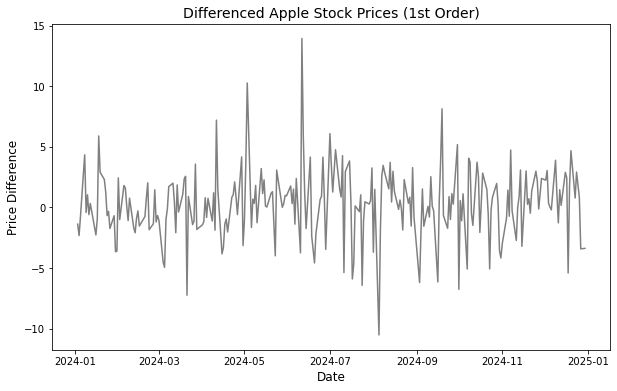

In [9]:
# Take the first difference of the Apple stock closing prices
diff_series = appl.diff().dropna()

# Plot the differenced series
plt.figure(figsize=(10,6))
plt.plot(diff_series, color='grey', linewidth=1.5)
plt.title("Differenced Apple Stock Prices (1st Order)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price Difference", fontsize=12)
plt.show()


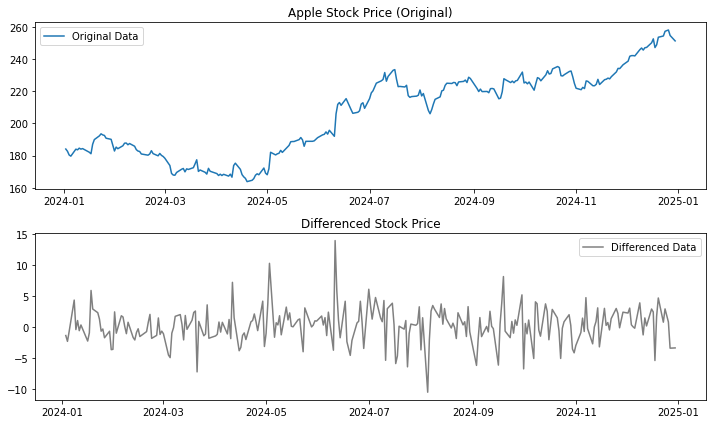

In [10]:
# Plot the original and differenced data
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(appl, label='Original Data')
plt.title('Apple Stock Price (Original)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(diff_series, label='Differenced Data', color='grey')
plt.title('Differenced Stock Price')
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
# Perform ADF test to check if the differenced series is stationary
adf_result = adfuller(diff_series)

# Print results
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

if adf_result[1] < 0.05:
    print("Reject the null hypothesis → Series is stationary")
else:
    print("Fail to reject the null hypothesis → Series is non-stationary")

ADF Statistic: -14.80155247341181
p-value: 2.095756329268587e-27
Critical Values: {'1%': -3.4568881317725864, '5%': -2.8732185133016057, '10%': -2.5729936189738876}
Reject the null hypothesis → Series is stationary


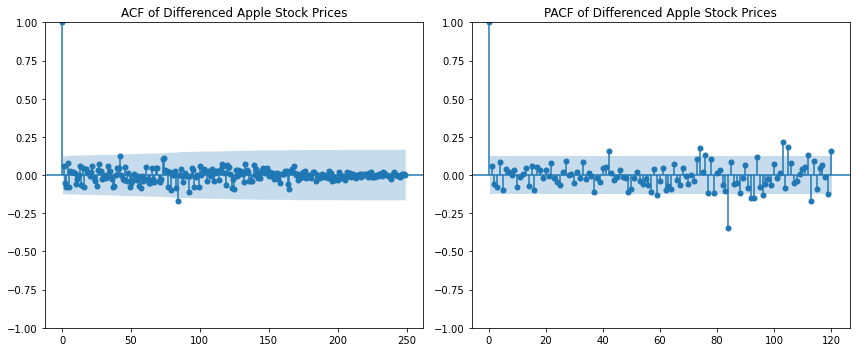

In [13]:
# Plot ACF., PACF of the differenced series
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plot_acf(diff_series, lags=249, ax=plt.gca())
plt.title('ACF of Differenced Apple Stock Prices')

plt.subplot(1,2,2)
plot_pacf(diff_series, lags=120, ax=plt.gca())
plt.title('PACF of Differenced Apple Stock Prices')

plt.tight_layout()
plt.show()

### AIC/ BIC

In [14]:
orders = [(1,1,0), (0,1,1), (1,1,1), (2,1,1)]
results = {}

for order in orders:
    model = ARIMA(stock_data['Close'], order=order)
    fitted = model.fit()
    results[order] = (fitted.aic, fitted.bic)

for order, (aic, bic) in results.items():
    print(f"ARIMA{order} - AIC: {aic:.2f}, BIC: {bic:.2f}")

ARIMA(1, 1, 0) - AIC: 1239.92, BIC: 1246.97
ARIMA(0, 1, 1) - AIC: 1239.83, BIC: 1246.87
ARIMA(1, 1, 1) - AIC: 1241.76, BIC: 1252.33
ARIMA(2, 1, 1) - AIC: 1243.09, BIC: 1257.17


### Model Building

In [15]:
# Fit ARIMA model
model = ARIMA(stock_data['Close'], order=(0, 1, 1))
model_fit = model.fit()

# Print the summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                  251
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -617.914
Date:                Sun, 14 Sep 2025   AIC                           1239.829
Time:                        19:36:46   BIC                           1246.872
Sample:                             0   HQIC                          1242.663
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0713      0.057      1.250      0.211      -0.040       0.183
sigma2         8.2105      0.482     17.021      0.000       7.265       9.156
Ljung-Box (L1) (Q):                   0.03   Jarque-

### Prediction

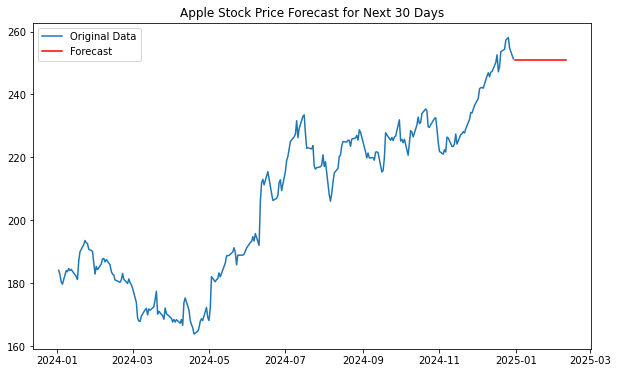

In [17]:
# Forecast the next 30 days
forecast = model_fit.forecast(steps=30)
forecast_steps = 30
# Ensure forecast is a 1D array (it should already be 1D, but let's enforce it)
forecast = np.array(forecast).flatten()

# Generate the dates for the forecast
forecast_dates = pd.date_range(stock_data.index[-1], periods=forecast_steps + 1, freq='B')[1:]

# Ensure forecast_dates is also a 1D array
forecast_dates = np.array(forecast_dates)

# Plot the original stock prices and the forecast
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Close'], label='Original Data')
plt.plot(forecast_dates, forecast, label='Forecast', color='red')
plt.title('Apple Stock Price Forecast for Next 30 Days')
plt.legend()
plt.show()

In [18]:
forecast[0:5]

array([251.0847536, 251.0847536, 251.0847536, 251.0847536, 251.0847536])

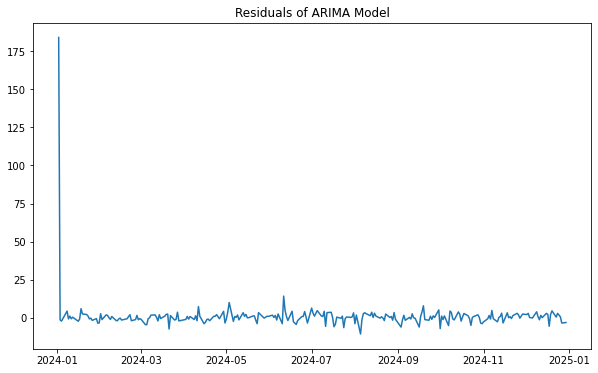

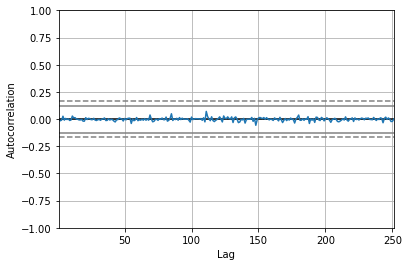

In [19]:
# Plot residuals to understand the error term
residuals = model_fit.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.show()

# Plot the ACF of residuals to check for autocorrelation
autocorrelation_plot(residuals)
plt.show()

### Evaluation Metrics

In [66]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Get the actual and predicted prices for evaluation
# In this example, we are predicting the next 30 days, so we only compare with the last 30 actual prices
actual_prices = stock_data['Close'][-forecast_steps:].values
predicted_prices = forecast

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(actual_prices, predicted_prices)
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 10.425572537162328
Mean Squared Error (MSE): 176.02274580305829
Root Mean Squared Error (RMSE): 13.267356398433648


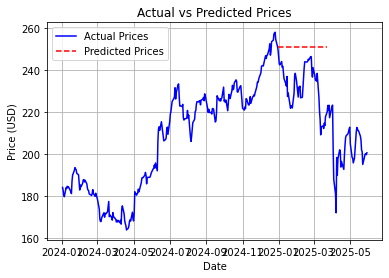

In [24]:
# Another way to plot
# Your forecast
forecast_steps2 = 60
forecast2 = model_fit.forecast(steps=forecast_steps2)
forecast2 = np.array(forecast2).flatten()

# Convert dates to numpy arrays explicitly
forecast_dates2 = pd.date_range(stock_data.index[-1], periods=forecast_steps2 + 1, freq='B')[1:]
forecast_dates2 = forecast_dates2.to_numpy()

actual_data = yf.download("AAPL", start="2024-01-01", end="2025-06-01", progress=False)
actual_prices = actual_data['Close'].to_numpy()
actual_dates = actual_data.index.to_numpy()
actual_dates_np = actual_dates.to_numpy() if hasattr(actual_dates, 'to_numpy') else np.array(actual_dates)

# Plot actual prices
plt.plot(actual_dates_np, actual_prices, label='Actual Prices', color='blue')

# Plot predicted prices
plt.plot(forecast_dates2, forecast2, label='Predicted Prices', color='red', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.grid(True)
plt.show()
